# QOSF Mentorship: Task 4

To review, the objective of Task 4 was to create a VQE-like circuit from scratch and use this circuit to find the lowest eigenvalue state of the following matrix:

$$\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

This notebook is organized into 4 parts:

1. Concepts and implementation of the VQE Circuit
2. Notes and thoughts on Python implementation
3. Experimenting with classical optimizers and noise models
4. Where do we go from here?



## Concepts and implementation of the VQE Circuit
In order to create this VQE circuit from scratch, we will need to implement the following parts:

    1. Decompose our Hamiltonian 
    2. Compose quantum circuit 
         1. Insert ansatz
         2. Insert (applicable) pre-measurement rotations
         3. Measure!
    3. Calculate expectation values 
    4. Sum the expectation values and return the ground state (lowest eigenvalue)

Alright, we have a plan, let's get to it!

(sidenote: this notebook will not touch on every VQE concept except the ones that are relevant to each step, for a more detailed look into the mechanics of VQE check out one of the wonderful sources below)

https://www.mustythoughts.com/variational-quantum-eigensolver-explained

https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb

#### Step 1: Decompose our Hamiltonian

We can't simply throw a hamiltonian of any size into our VQE circuit and calculate the lowest eigenvalue state. That would be like trying to eat an entire XL pizza in one bite. Instead, we want to break up the Hamiltonian into a sum of Pauli matrices, or in this 2-qubit case, the sum of tensored product of Pauli matrices.

For this task we are allowed to decompose our Hamiltonian into four distinct states (II, XX, YY, and ZZ). We can imagine our generalized Hamiltonian decomposed into its constituent tensored Pauli matrices like so:

$$H = a (I \otimes I)  +  b (\sigma_x \otimes \sigma_x)  +  c (\sigma_y \otimes \sigma_y)  +  d (\sigma_z \otimes \sigma_z) $$

The a, b, c, d values are coefficients for each decomposed matrix and work as a "weight" when multiplied with the expectation value. 

In order to decompose our hamiltonian we need to calculate the trace of each tensored pauli matrix above. We can do that by applying the trace formula to each pauli matrix in the hamiltonian:

$$ h_{ij} = \dfrac{1}{4} (\sigma_i \otimes \sigma_j * H)$$

For example, the trace for $\sigma_z \otimes \sigma_z$ is 0.5 as shown below:

$$ h_{zz} = \dfrac{1}{4} tr(\sigma_z \otimes \sigma_z * H)$$

$$ h_{zz} = \dfrac{1}{4} tr(\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix})$$

$$ h_{zz} = \dfrac{1}{4} tr(\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix})$$

$$ h_{zz} = \dfrac{1}{4} * 2$$

$$ h_{zz} = 0.5$$


We repeat this process for $(\sigma_x \otimes \sigma_x)$, $(\sigma_y \otimes \sigma_y)$, and $(I \otimes I)$: 

$$ h_{zz} = 0.5 \qquad h_{ii} = 0.5 \qquad h_{yy} = -0.5 \qquad h_{xx} = -0.5$$


Putting all these pieces together, we have now decomposed our hamiltonian into Pauli matrices which means that we are ready to calculate our ground state using our VQE circuit.

    
$$H = 0.5 (I \otimes I)  -  0.5 (\sigma_x \otimes \sigma_x)  -  0.5 (\sigma_y \otimes \sigma_y)  +  0.5 (\sigma_z \otimes \sigma_z) $$


You can decompose hamiltonians with ease using the snippet below:

In [1]:
from vqe import VQE
import numpy as np
import matplotlib.pyplot as plt
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error
from skquant.opt import minimize

In [2]:
ham = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
print(vqe.decompose_hamiltonian(hamiltonian=ham))

{'II': (0.5+0j), 'XX': (-0.5+0j), 'YY': (-0.5+0j), 'ZZ': (0.5+0j)}


#### Step 2: Compose VQE Circuit

Before we dive straight into the circuit specifics, I believe it's worthwhile getting a understanding of the overall process of the VQE algorithm. 

    1. Determine an initial value for theta
    2. Construct circuit and run simulator for theta 
    3. Use simulator results to calculate expectation values 
    4. Use expectation values to calculate energy value
    5. Choose another value for theta and repeat steps 1 - 4 until full range of theta has been calculated.
    6. Lowest value for theta will be ground state

![overview](images/overview.PNG)

As we tweak the value of our parameter theta, we get a different ground state value from our VQE algorithm. Our objective is to find the lowest eigenvalue by manipulating the value of theta. (Observant readers will recognize an opportunity to optimize this process, but that is a topic for another time!) Thanks to the Variational principle we know that any theta we provide to our VQE algorithm will never produce an energy state lower than the lowest eigenvalue but in fact slowly approach it. This fact underpins the effectiveness of this algorithm. Of course, like any quantum algorithm/circuit these facts ring true under ideal circumstances with no noise. However, we know that is not the reality of NISQ-era quantum computers. Later in this notebook we'll explore the way that noise effects our algorithm's ability to locate the ground state.

Our VQE circuit is composed of three distinct stages. First is the ansatz, second is the pre-measurement rotations and third is the measurements. 


### The Ansatz

Our ansatz consists of three gates the Hadamard gate (acting on the 1st qubit), the 2-qubit CNOT gate, and the parametrized $RX(\theta)$ gate (acting on the first qubit). The ansatz allows us to trasform our initial $\left| 00 \right\rangle$ state into the arbitrary state $\left| \psi \right\rangle$. Additionally the ansatz represents the space on the Bloch Sphere that is searchable for the ground state.    
    
    
### The Pre-measurement rotations 

A crucial step before we measure our qubits is to apply pre-measurement rotations. Why do we need to do this? We conduct all measurements in the Z axis in order to get results in the computational basis vectors 0 and 1. So this brings up the question of what to do if we have psi states along the X and Y axes. When we measure in the X axis we perform a $RY(-\pi/2)$ rotation, and we perform a $RX(\pi/2)$ rotation when measuring in the Y axis. No rotations need to be applied when measuring in the Z axis. Because of these differences our quantum circuit can look different considering which axis we are measuring in.


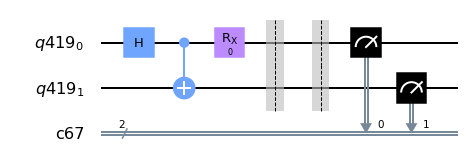

In [18]:
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Z")
circuit.draw("mpl")

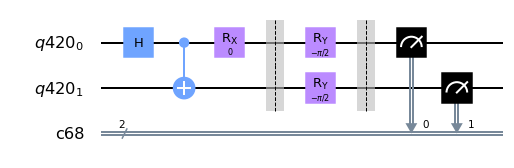

In [19]:
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("X")
circuit.draw("mpl")

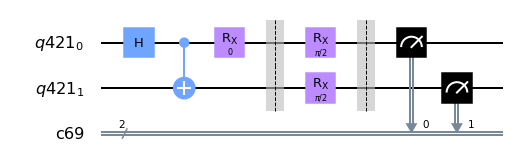

In [20]:
vqe = VQE(shots=1000, angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Y")
circuit.draw("mpl")

## Measurement 
    
Finally, we are ready to measure! Since this is a two qubit gate, we store the outcome of qubit 1 on a classical bit 1 and the outcome of qubit 2 onto classical bit 2. Therefore our results can be at most spread across 4 possible, 2-qubit states:  00, 01, 10, 11. 

Due to our pre-measurement rotations we can calculate all our measurements on the state ZZ. Recall that quantum  measurements take the form: $$\left\langle \psi \right| \sigma_z \otimes \sigma_z \left| \psi \right\rangle$$

We can interpret measurement by calculating the arbitrary state $\left| \psi \right\rangle$ with our four possible state to determine whether we end up with a an eigenvalue of 1 or -1

$$\left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle \qquad \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle \qquad \left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle \qquad \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle \qquad$$

Let's quickly do the calculations here:

$$ \left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle = \left\langle 00 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 00 \right\rangle \qquad \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle = \left\langle 01 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 01 \right\rangle$$

$$\left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle = \left\langle 10 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 10 \right\rangle \qquad \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle = \left\langle 11 \right| \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \left| 11 \right\rangle$$

When each of these matrices are multiplied, we end up with the following corresponding eigenvalues:

$$ \left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle = 1 \qquad \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle = -1 \qquad \left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle = -1 \qquad \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle = 1 $$

### Step 3: Calculate Expectation Values 

At this point our quantum simulator has run a 1000 simulations and has provided us with the results in this dictionary format with each possible state as the key and the number of times that state was manifested as the value:

```
    "00": 491,"01": 13,"10": 11,"11": 485
```

The calculation of the expectation value is average of the sum of results. Let $C$ be the total shots, where $C_{ij}$ is the total number of measurements for state $ij$. 

$$expectation = \dfrac{C_{00} - C_{01} - C_{10} + C_{11}}{C_{total}}$$

Why do $C_{01}$ and $C_{10}$ have negative coefficients? If you refer to the previous section, the eigenvalues for states $\left| 01 \right\rangle$ and $\left| 10 \right\rangle$ are both -1


Below are some runs for measurements made on the Z, Y, X basis for theta = 0.


In [7]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Z")
results = vqe.execute_measurement(circuit)
print("Expectation value for ZZ: ", vqe.calculate_expectation_values(results, "Z"))

Expectation value for ZZ:  1.0


In [8]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("X")
results = vqe.execute_measurement(circuit)
print("Expectation value for XX: ", vqe.calculate_expectation_values(results, "X"))

Expectation value for XX:  1.0


In [9]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
circuit = vqe.generate_circuit("Y")
results = vqe.execute_measurement(circuit)
print("Expectation value for YY: ", vqe.calculate_expectation_values(results, "Y"))

Expectation value for YY:  -1.0


#### Step 4: Return Lowest Eigenvalue

We return all the way back to where we started, to our decomposed Hamiltonian 

$$H = 0.5 (I \otimes I)  -  0.5 (\sigma_x \otimes \sigma_x)  -  0.5 (\sigma_y \otimes \sigma_y)  +  0.5 (\sigma_z \otimes \sigma_z) $$

For a given theta, executing step 1 through step 4 of our process provides us with a value for each part of this decomposed Hamiltonian. These values are summed, giving us the energy state for the given theta. At this point, the VQE algorithm will provide another value for theta and repeat this process generating a unique ground state value for this new theta. Rinse and repeat. Since there is no classical optimizer we simply step through each theta value in the provided angle range (for this task we will use $0$ to $2\pi$) and loop through each one.

In order to find the lowest eigenvalue (the ground state) we use the `min()` Python function to identify that lowest value in the list.

![ground](images/ground_state.PNG)

#### Putting the pieces together

Now that we have thoroughly outlined the process, we now execute the VQE algorithm to find the lowest eigenvalue for the matrix provided at the beginning of this document. 

Let's run our VQE algorithm!

Before we run our quantum algorithm, let's run the classical one to get a baseline for the ground state of the matrix.


In [22]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.run_classical_eigensolver(0.5, 0.5, -0.5, -0.5)

NameError: name 'WeightedPauliOperator' is not defined

In [23]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.find_ground_state()

Ground state: -0.99
Angle (theta) for ground state:  2.9762456718219092


## Notes and thoughts on Python implementation

Running `vqe.decompose_hamiltonian()` will output the ground state as well as the angle (theta) that corresponds to the ground state. However, running the `decompose_hamiltonian()` function actually stores a vast array of data that is useful and structured. 

After running `vqe.decompose_hamiltonian()` the user can then run `vqe.return_vqe_info()` to receive a JSON object with the following data.

In order to get an entry for `classical_ground_state`, run `vqe.run_classical_eigensolver()` and 

The idea for this came through my own struggles with trying to debug or create useful graphs/visualizations when the only data point coming back was a single value for the ground state. With this JSON object users have the flexibility to feed this structured data into their own functions to work with the data in a predictable fasion.


In [11]:
vqe = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
vqe.find_ground_state()
print(vqe.return_vqe_info())

Ground state: -0.988
Angle (theta) for ground state:  2.9762456718219092
{
    "estimated_energy": {
        "0.0": 1.0,
        "0.3306939635357677": 0.948,
        "0.6613879270715354": 0.792,
        "0.992081890607303": 0.5549999999999999,
        "1.3227758541430708": 0.23399999999999999,
        "1.6534698176788385": -0.06500000000000006,
        "1.984163781214606": -0.43399999999999994,
        "2.3148577447503738": -0.677,
        "2.6455517082861415": -0.883,
        "2.9762456718219092": -0.988,
        "3.306939635357677": -0.988,
        "3.6376335988934447": -0.885,
        "3.968327562429212": -0.6949999999999998,
        "4.29902152596498": -0.353,
        "4.6297154895007475": -0.039000000000000035,
        "4.960409453036515": 0.236,
        "5.291103416572283": 0.515,
        "5.621797380108051": 0.778,
        "5.9524913436438185": 0.928,
        "6.283185307179586": 1.0
    },
    "simulator_results": {
        "0.0": {
            "Z": {
                "00": 516,

## Experimenting with classical optimizers and noise models

The VQE algorithm is part of the hybrid classical-quantum algorithm category because of the way that simulations are executed quantumly while the optimization is done classically. 

![hybrid](images/hybrid.png)

As part of Task 4, we did not use an optimizer to find the best value for theta that would return the ground state. Classical optimizers offer a more efficient and intelligent way of figuring out the optimal value for theta. This section of research is largely inspired by the paper: [Classical Optimizers for Noisy Intermediate-Scale Quantum Devices](https://arxiv.org/pdf/2004.03004.pdf) which lays out a number of known classical optimizers in the `scikit-quant` library that can be used to simulate the effects of these optimizers on our VQE circuit. The ones I chose to experiment with is `Imfil`and `PyBobyqa`. I tried out `SnobFit` but was unable to get it working correctly.

- SnobFit and NOMAD are good for smooth surfaces, while ImFil and NOMAD are good for non-smooth surfaces


Thinking about it intuitively one would imagine that error in the form of noise would throw us way off course from finding the correct ground state maybe even bounce us around. However, that is not the type of error that we encounter! In a more sinister way, noise in our simulation prevents our algorithm from ever identifying the correct ground state to begin with! Noise prevents our algorithm from approaching the true minimum eigenvalue. 

Smoothness of the curve lends to more efficient optimization, sharp edges causes areas of issues for the optimizer


#### The effects of noise on optimizers 

The effect of noise on VQE is very peculiar. Overall I was expecting that as the amount of noise increased, the graph would cease to have a shape and become a mess of random scattered lines, surprisingly that was not the case. Even under 30 and 40% error probabilities, the ground state still converged at a global minima. 

In this example below, I added 30% depolarizing noise to both the RX and H gates. From this example we can see that the convex shape is very much still in tact with its maximum correctly placed at 1 BUT it's lowest energy state has lifted completed from the actual ground state of -1. The affect of noise (even at small amounts) can be devastating because it completely prevents us from getting an accurate reading on the ground state. In this example, under 30% noise our minima registers at `-0.701`. 


Ground state: -0.9910000000000001
Angle (theta) for ground state:  2.9762456718219092
Ground state: -0.7010000000000001
Angle (theta) for ground state:  2.9762456718219092


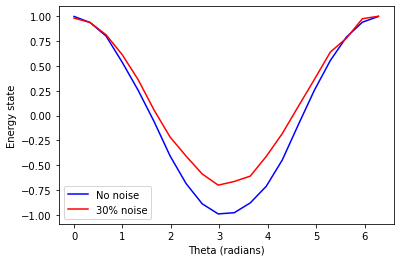

In [6]:
angle_range = np.linspace(0, 2 * np.pi, 20)
noise_model = NoiseModel()
error = depolarizing_error(0.3, 1)
noise_model.add_all_qubit_quantum_error(error, ['h', 'rx'])
m_list = []

vqe = VQE(angle_range=angle_range)
vqe.find_ground_state()
results = vqe.return_vqe_info()
res = []
for key, value in results["estimated_energy"].items():
    res.append(results["estimated_energy"][key])

m_list.append(res)


sec_vqe = VQE(angle_range=angle_range, noise=noise_model)
sec_vqe.find_ground_state()
sec_results = sec_vqe.return_vqe_info()
sec_res = []
for key, value in sec_results["estimated_energy"].items():
    sec_res.append(sec_results["estimated_energy"][key])

m_list.append(sec_res)
plt.plot(angle_range, m_list[0], color='blue', label='No noise')
plt.plot(angle_range, m_list[1], color='red', label="30% noise")
plt.xlabel('Angle (radians)') 
plt.ylabel('Energy state') 
plt.legend()
plt.show()

Another subtle characteristic of the effect of noise on VQE is the small amounts of sharper edges starting to form on the red line as opposed to the blue. These sharper edge can make our classical optimizers run through additional intervals. The paper suggests that the smoothness of the curve lends to more efficient optimization, sharp edges causes areas of issues for the optimizer. 

So let's see this in action with a classical optimizer such as `imfil` 



In terms of how noise effects optimizers, here too I was surprised. I expected that with increased noise the optimizer would become unable to determine the correct ground state, however, the optimizer was able to do this. Instead we observe that the optimizer wastes a lot of cycles going back and forth due to the small increases in non-smooth edges. The more jagged and pronounced lines caused the optimizer to "freak out" even more. 


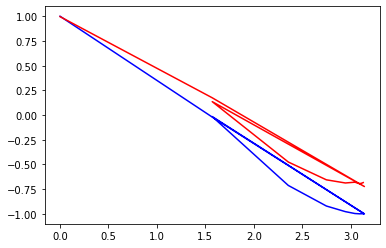

In [7]:
energy = []
radians = []
bounds = np.array([[0, np.pi]], dtype=float)
budget = 100
initial_point = np.array([0], dtype=float)


obj = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
result, history = minimize(obj.get_energy_state, initial_point, bounds, budget, method='imfil')
e1 = []
r1 = []
for h in history:
    e1.append(h[0])
    r1.append(h[1])

energy.append(e1)
radians.append(r1)

obj = VQE(angle_range=np.linspace(0, 2 * np.pi, 20), noise=noise_model)
result, history = minimize(obj.get_energy_state, initial_point, bounds, budget, method='imfil')
e2 = []
r2 = []
for h in history:
    e2.append(h[0])
    r2.append(h[1])

energy.append(e2)
radians.append(r2)

plt.plot(radians[0], energy[0], color='blue')
plt.plot(radians[1], energy[1], color='red')
plt.xlabel('Angle (radians)') 
plt.ylabel('Energy state') 
plt.legend()
plt.show()


/Users/pchung/Desktop/qosf_mentorship_2020/venv/lib/python3.7/site-packages/pybobyqa/solver.py:795: RuntimeWarning: x0 below lower bound, adjusting
  warnings.warn("x0 below lower bound, adjusting", RuntimeWarning)


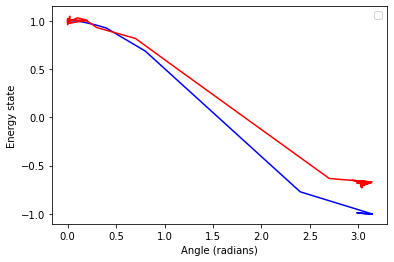

In [8]:
energy = []
radians = []
bounds = np.array([[0, np.pi]], dtype=float)
budget = 100
initial_point = np.array([0], dtype=float)

obj = VQE(angle_range=np.linspace(0, 2 * np.pi, 20))
result, history = minimize(obj.get_energy_state, initial_point, bounds, budget, method='pybobyqa')
e1 = []
r1 = []
for h in history:
    e1.append(h[0])
    r1.append(h[1])

energy.append(e1)
radians.append(r1)

obj = VQE(angle_range=np.linspace(0, 2 * np.pi, 20), noise=noise_model)
result, history = minimize(obj.get_energy_state, initial_point, bounds, budget, method='pybobyqa')
e2 = []
r2 = []
for h in history:
    e2.append(h[0])
    r2.append(h[1])

energy.append(e2)
radians.append(r2)

plt.plot(radians[0], energy[0], color='blue')
plt.plot(radians[1], energy[1], color='red')
plt.xlabel('Angle (radians)') 
plt.ylabel('Energy state') 
plt.legend()
plt.show()

## Where do we go from here?

How do we correct errors from noise in VQE? are there algorithms and circuit design for this?
The art of figuring out a good ansatz? What are the parameters for "goodness" of an ansatz?
From diving into classical optimizers I became more interested in the idea of quantum optimization algorithms such as  QAOA (Quantum Appromixation )